In [1]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [2]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

True


In [3]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\test_data"

In [98]:
batch_size = 2

In [99]:
def train_gen(suj_path,mask_path):
    
    datagen = ImageDataGenerator(rescale=1./255)
    seed = 777
    
    image_train_generator = datagen.flow_from_directory(suj_path,class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=batch_size,seed=seed)
    mask_train_generator = datagen.flow_from_directory(mask_path,class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=batch_size,seed=seed)
    
    train_generator = zip(image_train_generator, mask_train_generator)

    for img,mask in train_generator:
        yield(img,mask)

In [100]:
train_gen_ds = train_gen(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = train_gen(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))


In [101]:
x,y = train_gen_ds.__next__()

Found 2720 images belonging to 1 classes.
Found 2720 images belonging to 1 classes.


In [102]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(2, 384, 384, 1)
(2, 384, 384, 1)
0.7254902 0.0
1.0 0.0


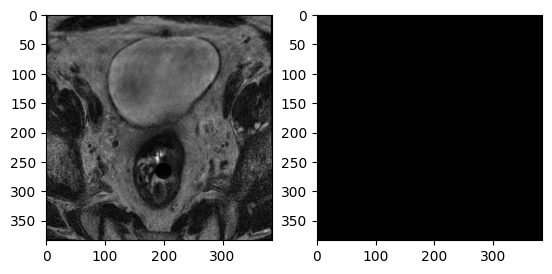

In [104]:
x,y = train_gen_ds.__next__()
for i in range(0,batch_size-1):
    image = x[i,:,:,0]
    mask = y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap="gray")
    plt.show

In [105]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos","img")))
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos","img")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

2720 1167


---


In [106]:
keras.backend.clear_session()

In [107]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [108]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model

In [109]:
from keras import backend as K

In [110]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [111]:
my_unet = build_unet(input_shape=(384,384,1), n_classes= 1)
#print(my_unet.summary())
my_unet.compile(optimizer=Adam(learning_rate = 1e-3), loss=dice_coef_loss, metrics=[dice_coef])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [117]:
history = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=50,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=[early_stopping_cb])

Epoch 1/50
1360/1360 [==============================] - 408s 299ms/step - loss: 0.4996 - dice_coef: 0.5004 - val_loss: 0.4033 - val_dice_coef: 0.5967
Epoch 2/50
1360/1360 [==============================] - 441s 325ms/step - loss: 0.4891 - dice_coef: 0.5109 - val_loss: 0.4958 - val_dice_coef: 0.5042
Epoch 3/50
1360/1360 [==============================] - 577s 424ms/step - loss: 0.4679 - dice_coef: 0.5321 - val_loss: 0.4766 - val_dice_coef: 0.5234
Epoch 4/50
1360/1360 [==============================] - 575s 423ms/step - loss: 0.4513 - dice_coef: 0.5487 - val_loss: 0.3636 - val_dice_coef: 0.6364
Epoch 5/50
1360/1360 [==============================] - 531s 390ms/step - loss: 0.4432 - dice_coef: 0.5568 - val_loss: 0.2922 - val_dice_coef: 0.7078
Epoch 6/50
1360/1360 [==============================] - 531s 390ms/step - loss: 0.4350 - dice_coef: 0.5650 - val_loss: 0.3789 - val_dice_coef: 0.6211
Epoch 7/50
1360/1360 [==============================] - 531s 390ms/step - loss: 0.4211 - dice_coef: 

In [120]:
history.history['dice_coef']

[0.5004405379295349,
 0.5108750462532043,
 0.5321138501167297,
 0.5486522912979126,
 0.5567615032196045,
 0.5649707317352295,
 0.5789188742637634,
 0.5739774107933044,
 0.5890570878982544,
 0.5922093391418457,
 0.6110786199569702,
 0.6097009181976318,
 0.6016595959663391,
 0.6168844103813171,
 0.6227771043777466,
 0.6138597130775452,
 0.6188784241676331,
 0.3996511995792389]

In [118]:
my_unet.save("test.hdf5")

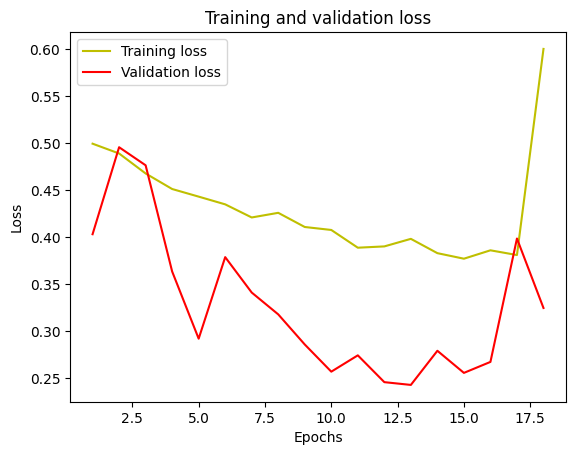

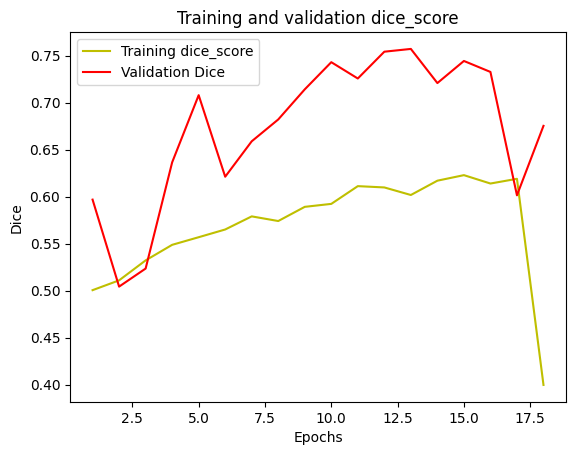

In [122]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [148]:

y_pred=my_unet.predict(test_image_batch)
y_argmax = np.argmax(test_mask_batch, axis=3)
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 22ms/step
Mean IoU = 1.0


1/1 [==============================] - 0s 23ms/step
Mean IoU = 0.9416238


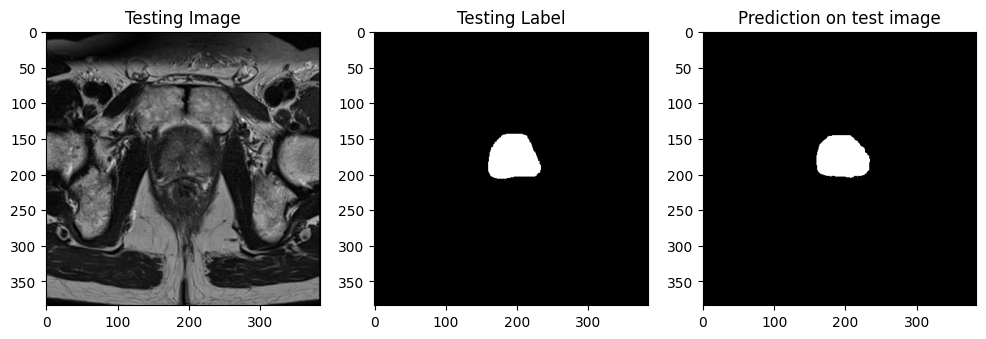

In [247]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()